<a href="https://colab.research.google.com/github/Gabriele90/ML-for-histopathology/blob/main/ResNet%20model%20to%20identify%20colon%20adenocarcinoma%20in%20digital%20pathology%20scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**

The aim of this study is to classify histopatholical images to detect cancer tissue or benign tissue. 

I decided to apply the **ResNet model**. The core idea of this model is introducing a so-called “identity shortcut connection” that skips one or more layers and features heavy batch normalization. Such skip connections are also known as gated units or gated recurrent units and have a strong similarity to recent successful elements applied in RNNs. Thanks to this technique we are able to train a NN with 152 layers while still having lower complexity than VGGNet.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.keras.metrics import Metric
from typeguard import typechecked
from typing import Optional

import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

**Dataset description**

This dataset contains 10.000 histopathological images with 2 classes:

Colon adenocarcinoma

Colon benign tissue

All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.

In [ ]:
!pip install split_folders
import splitfolders

In [ ]:
input_folder = '/content/drive/MyDrive/colon_image_sets'
output_folder = '/content/drive/MyDrive/output'

In [ ]:
splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None) 

**Setting the working directories**

In [ ]:
#set the path to the main dir
import os
main_dir = "/content/drive/MyDrive/output"
#set the path to the train dir
train_dir = os.path.join(main_dir,'train')
#set the path to the test dir
test_dir = os.path.join(main_dir,'test')
#set the path to the val dir
val_dir = os.path.join(main_dir,'val')
#directory with the training adenocarcinoma images
train_aca_dir = os.path.join(train_dir, 'colon_aca')
#directory with the training no tumor images
train_n_dir = os.path.join(train_dir, 'colon_n')
#directory with the test adenocarcinoma images
test_aca_dir = os.path.join(test_dir, 'colon_aca')
#directory with the test no tumor images
test_n_dir = os.path.join(test_dir, 'colon_n')
#directory with the val adenocarcinoma images
val_aca_dir = os.path.join(val_dir, 'colon_aca')
#directory with the val no tumor images
val_n_dir = os.path.join(val_dir, 'colon_n')

In [ ]:
train_aca_names = os.listdir(train_aca_dir)
print(train_aca_names[:5])

train_n_names = os.listdir(train_n_dir)
print(train_n_names[:5])

test_aca_names = os.listdir(test_aca_dir)
print(test_aca_names[:5])

test_n_names = os.listdir(test_n_dir)
print(test_n_names[:5])

val_aca_names = os.listdir(val_aca_dir)
print(val_aca_names[:5])

val_n_names = os.listdir(val_n_dir)
print(val_n_names[:5])

['colonca4380.jpeg', 'colonca4399.jpeg', 'colonca4373.jpeg', 'colonca4370.jpeg', 'colonca4392.jpeg']
['colonn4367.jpeg', 'colonn4376.jpeg', 'colonn4394.jpeg', 'colonn4371.jpeg', 'colonn4388.jpeg']
['colonca101.jpeg', 'colonca10.jpeg', 'colonca1014.jpeg', 'colonca1019.jpeg', 'colonca1.jpeg']
['colonn1.jpeg', 'colonn10.jpeg', 'colonn1014.jpeg', 'colonn103.jpeg', 'colonn101.jpeg']
['colonca1013.jpeg', 'colonca1009.jpeg', 'colonca1036.jpeg', 'colonca108.jpeg', 'colonca1068.jpeg']
['colonn1013.jpeg', 'colonn1036.jpeg', 'colonn1009.jpeg', 'colonn1068.jpeg', 'colonn1097.jpeg']


In [ ]:
#print the total no of images present in each dir
print("Total images in the training set:", len(train_aca_names+train_n_names))
print("Total images in the test set:", len(test_aca_names+test_n_names))
print("Total images in the val set:", len(val_aca_names+val_n_names))

Total images in the training set: 8000
Total images in the test set: 1000
Total images in the val set: 1000


**Data visualization**

In [ ]:
#training
train_aca_names = os.listdir(train_aca_dir)
print(train_aca_names[:5])
train_n_names = os.listdir(train_n_dir)
print(train_n_names[:5])
#test
test_aca_names = os.listdir(test_aca_dir)
print(test_aca_names[:5])
test_n_names = os.listdir(test_n_dir)
print(test_n_names[:5])
#val
val_aca_names = os.listdir(val_aca_dir)
print(val_aca_names[:5])
val_n_names = os.listdir(val_n_dir)
print(val_n_names[:5])

['colonca4380.jpeg', 'colonca4399.jpeg', 'colonca4373.jpeg', 'colonca4370.jpeg', 'colonca4392.jpeg']
['colonn4367.jpeg', 'colonn4376.jpeg', 'colonn4394.jpeg', 'colonn4371.jpeg', 'colonn4388.jpeg']
['colonca101.jpeg', 'colonca10.jpeg', 'colonca1014.jpeg', 'colonca1019.jpeg', 'colonca1.jpeg']
['colonn1.jpeg', 'colonn10.jpeg', 'colonn1014.jpeg', 'colonn103.jpeg', 'colonn101.jpeg']
['colonca1013.jpeg', 'colonca1009.jpeg', 'colonca1036.jpeg', 'colonca108.jpeg', 'colonca1068.jpeg']
['colonn1013.jpeg', 'colonn1036.jpeg', 'colonn1009.jpeg', 'colonn1068.jpeg', 'colonn1097.jpeg']


In [ ]:
#get the filenames from the mss and msi dir of the train dataset
aca_pic =[os.path.join(train_aca_dir, filename) for filename in train_aca_names[0:4]]
n_pic =[os.path.join(train_n_dir, filename) for filename in train_n_names[0:4]]

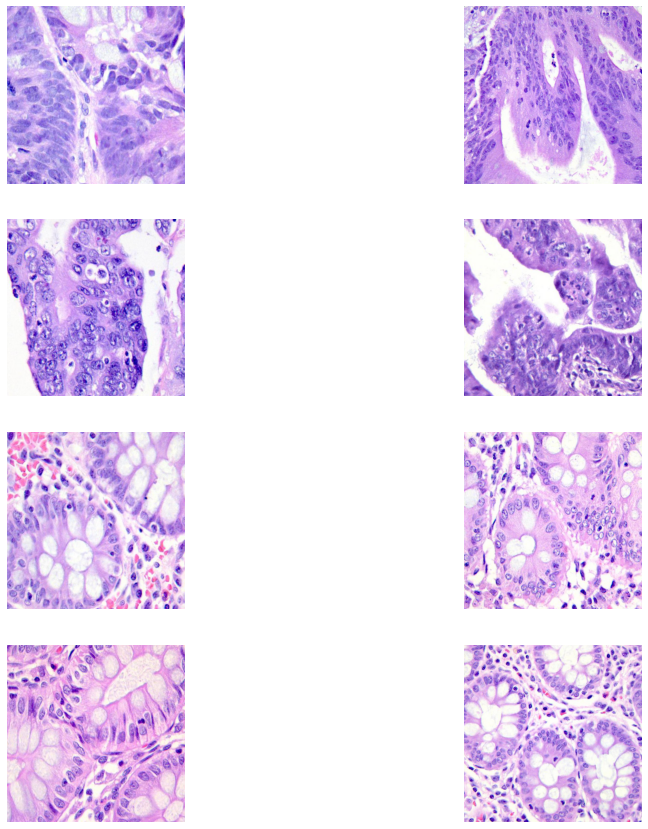

In [ ]:
import matplotlib.pyplot as plt
# plot a grid of 8 images (4 images of each class)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 2
#set the figure size
fig = plt.gcf()
fig.set_size_inches(15,15)
#merge the covid and normal list
merged_list = aca_pic+n_pic
for i , img_path in enumerate(merged_list):
  data= img_path.split('/', 2)[2] 
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  #sp.set_title(data, fontsize=11)
  plt.imshow(img,cmap='gray') 

  plt.show

**Data resizing (224 x 224) and x & y variables creation**

In [ ]:
x = []
y = []

for i in tqdm(os.listdir(train_aca_dir)):
    path = os.path.join(train_aca_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('ADENOCARCINOMA')

for i in tqdm(os.listdir(train_n_dir)):
    path = os.path.join(train_n_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('BENIGN')

100%|██████████| 4000/4000 [21:16<00:00,  3.13it/s]


In [ ]:
for i in tqdm(os.listdir(test_aca_dir)):
    path = os.path.join(test_aca_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('ADENOCARCINOMA')

for i in tqdm(os.listdir(test_n_dir)):
    path = os.path.join(test_n_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('BENIGN')

100%|██████████| 500/500 [02:33<00:00,  3.26it/s]


In [ ]:
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((9000, 224, 224, 3), (9000,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


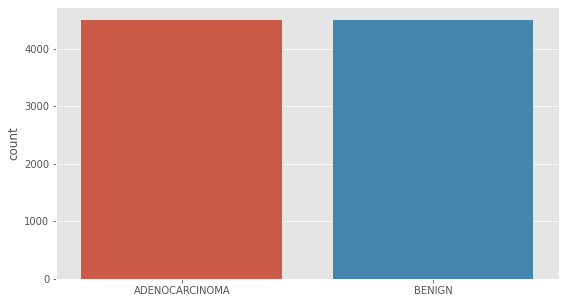

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y)
plt.show()

In [ ]:
y

array(['ADENOCARCINOMA', 'ADENOCARCINOMA', 'ADENOCARCINOMA', ...,
       'BENIGN', 'BENIGN', 'BENIGN'], dtype='<U14')

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
y = to_categorical(y)#num_classes = 2
y.shape

(9000, 2)

In [ ]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
y_test.shape

(1800, 2)

**Data Augmentation**

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [ ]:
# generate training,testing and validation batches 
dgen_train = ImageDataGenerator(rescale =1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip =True)
dgen_validation = ImageDataGenerator(rescale = 1./255)
dgen_test = ImageDataGenerator(rescale =1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(224,224),
                                                 subset='training',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = dgen_train.flow_from_directory(val_dir,
                                                 target_size=(224,224),
                                                 subset='validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(224,224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 6400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


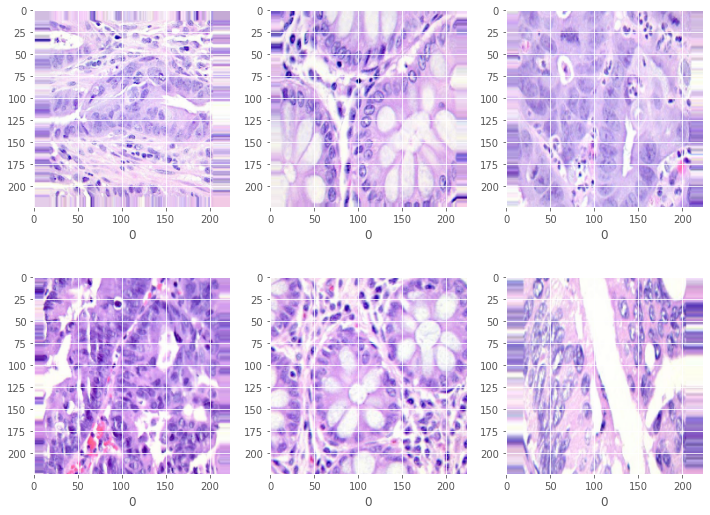

In [ ]:
from tensorflow.keras.preprocessing import image
sample_x,sample_y = next(train_generator)
plt.figure(figsize=(12,9))
for i in range(6):
    plt.subplot(2,3,i+1)
    sample = image.array_to_img(sample_x[i])
    plt.xlabel(np.argmax(sample_y[i]))
    plt.imshow(sample)
plt.show()

In [ ]:
#get the class indices
train_generator.class_indices

{'colon_aca': 0, 'colon_n': 1}

In [ ]:
#get the image shape
train_generator.image_shape

(224, 224, 3)

**Model architecture**

I used the so-called Residual Neural Network (ResNet) by Kaiming He et al. This architecture works with “skip connections” and features heavy batch normalization. Such skip connections are also known as gated units or gated recurrent units and have a strong similarity to recent successful elements applied in RNNs.

In [ ]:
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50

In [ ]:
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in base_model.layers:
  layer.trainable = False

234700800/234698864 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(2, activation = 'sigmoid')(x)

In [ ]:
model = Model(inputs = base_model.input, outputs = predictions)

**Defining the metrics**

F1-score, Precision, Recall and AUC score

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

**Compiling the model and setting checkpoint and optimizer**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy',metrics=METRICS)

In [ ]:
checkpoint = ModelCheckpoint( "ResNet" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [ ]:
history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=50, 
                        validation_data=(x_test, y_test),
                        callbacks=checkpoint)

Epoch 1/50
225/225 [==============================] - 78s 321ms/step - loss: 0.0249 - accuracy: 0.9939 - precision: 0.9941 - recall: 0.9937 - auc: 0.9984 - f1_score: 0.9939 - val_loss: 0.0518 - val_accuracy: 0.9919 - val_precision: 0.9890 - val_recall: 0.9950 - val_auc: 0.9957 - val_f1_score: 0.9921

Epoch 00001: val_accuracy improved from -inf to 0.99194, saving model to ResNet
INFO:tensorflow:Assets written to: ResNet/assets
Epoch 2/50
225/225 [==============================] - 63s 282ms/step - loss: 0.0237 - accuracy: 0.9949 - precision: 0.9945 - recall: 0.9954 - auc: 0.9983 - f1_score: 0.9950 - val_loss: 0.0481 - val_accuracy: 0.9942 - val_precision: 0.9983 - val_recall: 0.9900 - val_auc: 0.9966 - val_f1_score: 0.9942

Epoch 00002: val_accuracy improved from 0.99194 to 0.99417, saving model to ResNet
INFO:tensorflow:Assets written to: ResNet/assets
Epoch 3/50
225/225 [==============================] - 64s 286ms/step - loss: 0.0086 - accuracy: 0.9987 - precision: 0.9990 - recall: 0.

**Model Performance Evaluation**


In [ ]:
#get the keys of history object
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score'])

**Visualizing results**

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
  fig.suptitle(" METRICS VISUALIZATION ")
  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['training', 'validation'])
  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['training', 'validation'])
    
  ax3.plot(range(1, len(auc) + 1), auc)
  ax3.plot(range(1, len(val_auc) + 1), val_auc)
  ax3.set_title('History of AUC')
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('AUC')
  ax3.legend(['training', 'validation'])

  ax4.plot(range(1, len(precision) + 1), precision)
  ax4.plot(range(1, len(val_precision) + 1), val_precision)
  ax4.set_title('History of Precision')
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('Precision')
  ax4.legend(['training', 'validation'])
    
  ax5.plot(range(1, len(f1) + 1), f1)
  ax5.plot(range(1, len(val_f1) + 1), val_f1)
  ax5.set_title('History of F1-score')
  ax5.set_xlabel('Epochs')
  ax5.set_ylabel('F1 score')
  ax5.legend(['training', 'validation'])


  plt.show()

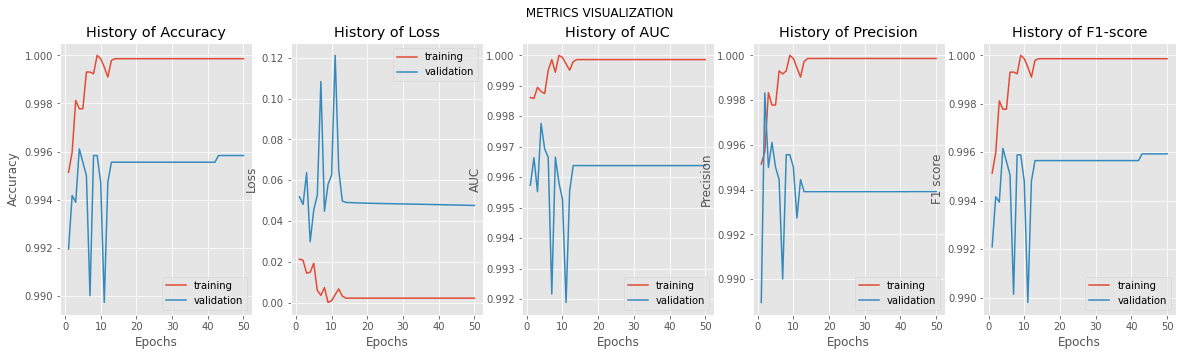

In [ ]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
                 history.history['loss'],history.history['val_loss'],
                 history.history['auc'],history.history['val_auc'],
                 history.history['precision'],history.history['val_precision'],
                 history.history['f1_score'],history.history['val_f1_score']
                 )  

In [ ]:
print('ResNet accuracy:', history.history['accuracy'][-1])
print('ResNet validation accuracy:', history.history['val_accuracy'][-1])
print('ResNet loss:', history.history['loss'][-1])
print('ResNet validation loss:', history.history['val_loss'][-1])
print('ResNet AUC:', history.history['auc'][-1])
print('ResNet validation AUC:', history.history['val_auc'][-1])
print('ResNet Precision:', history.history['precision'][-1])
print('ResNet validation Precision:', history.history['val_precision'][-1])
print('ResNet F1 score:', history.history['f1_score'][-1])
print('ResNet validation F1 score:', history.history['val_f1_score'][-1])

ResNet accuracy: 0.9998611211776733
ResNet validation accuracy: 0.9958333373069763
ResNet loss: 0.002130152191966772
ResNet validation loss: 0.047585826367139816
ResNet AUC: 0.9998611211776733
ResNet validation AUC: 0.9963824152946472
ResNet Precision: 0.9998611211776733
ResNet validation Precision: 0.9939125776290894
ResNet F1 score: 0.9998611211776733
ResNet validation F1 score: 0.9959345459938049


In [ ]:
y_pred= model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)
y_test_new = np.argmax(y_test,axis=1)

[0 1] [900 900]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
clf_report = classification_report(y_test_new,y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       896
           1       1.00      0.99      1.00       904

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



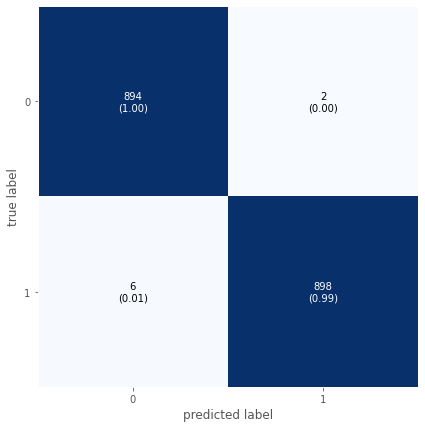

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_new,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                     show_normed=True);

As we can see, we achieved great scores for all metrics.

**Assessing the model on the test set**

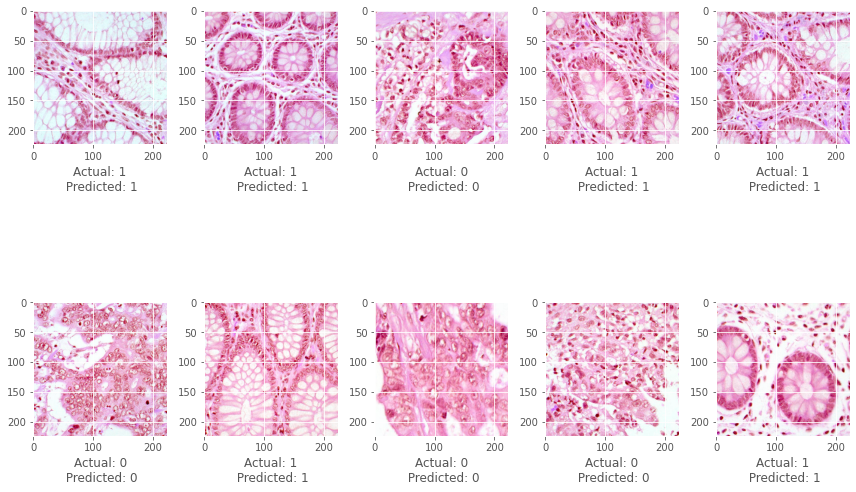

In [ ]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test_new[sample_idx]}\n Predicted: {y_pred[sample_idx]}")
    
plt.tight_layout()
plt.show()